# Look at the overview scans
Let's see what we did there.

In [1]:
import platform
import os
import glob
import pandas
import imageio
import numpy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn
import dask
import dask_image.imread
from dask.distributed import Client
client = Client()
# Then go to http://localhost:8787/status
from numcodecs import Blosc
import skimage
from tqdm import notebook

In [2]:
print('You can seee what DASK is doing at "http://localhost:%s/status"' % client.scheduler_info()['services']['dashboard'])

You can seee what DASK is doing at "http://localhost:8787/status"


In [3]:
# # Ignore warnings in the notebook
# import warnings
# warnings.filterwarnings("ignore")

In [4]:
# Set up figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit

In [5]:
# Setup scale bar defaults
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [6]:
# Display all plots identically
lines = 3
# And then do something like
# plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)

In [7]:
# Different locations if running either on Linux or Windows
FastSSD = False
# to speed things up significantly
if 'Linux' in platform.system():
    if FastSSD:
        BasePath = os.path.join(os.sep, 'media', 'habi', 'Fast_SSD')
    else:
        BasePath = os.path.join(os.sep, 'home', 'habi', '1272')
elif 'Darwin' in platform.system():
    FastSSD = False
    BasePath = os.path.join('/Users/habi/Dev/EAWAG/Data')
elif 'Windows' in platform.system():
    if FastSSD:
        BasePath = os.path.join('F:\\')
    else:
        if 'anaklin' in platform.node():
            BasePath = os.path.join('S:\\')
        else:
            BasePath = os.path.join('D:\\Results')
Root = os.path.join(BasePath, 'EAWAG')
print('We are loading all the data from %s' % Root)

We are loading all the data from D:\Results\EAWAG


In [8]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [9]:
def get_projectionsize(logfile):
    """How big did we set the camera?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Number Of Rows' in line:
                y = int(line.split('=')[1])
            if 'Number Of Columns' in line:
                x = int(line.split('=')[1])                
    return(x*y)

In [10]:
def get_filter(logfile):
    """Get the filter we used whole scanning from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Filter=' in line:
                whichfilter = line.split('=')[1].strip()
    return(whichfilter)

In [11]:
def get_exposuretime(logfile):
    """Get the exposure time size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Exposure' in line:
                exposuretime = int(line.split('=')[1])
    return(exposuretime)

In [12]:
def get_ringartefact(logfile):
    """Get the ring artefact correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Ring Artifact' in line:
                ringartefactcorrection = int(line.split('=')[1])
    return(ringartefactcorrection)

In [13]:
def get_reconstruction_grayvalue(logfile):
    grayvalue = None
    """How did we map the brightness of the reconstructions?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Maximum for' in line:
                grayvalue = float(line.split('=')[1])
    return(grayvalue)

In [14]:
def get_beamhardening(logfile):
    """Get the beamhardening correction from the  scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Hardening' in line:
                beamhardeningcorrection = int(line.split('=')[1])
    return(beamhardeningcorrection)

In [15]:
def get_rotationstep(logfile):
    """Get the rotation step from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Rotation Step' in line:
                rotstep = float(line.split('=')[1])
    return(rotstep)

In [16]:
def get_frameaveraging(logfile):
    """Get the frame averaging from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Averaging' in line:
                avg = line.split('=')[1]
    return(avg)

In [17]:
def get_machine(logfile):
    """Get the machine we used to scan"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Scanner' in line:
                machine = line.split('=')[1].strip()
    return(machine)

In [47]:
def get_scantime(logfile):
    """How long did we scan?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Scan duration' in line:
                time = line.split('=')[1].strip()
    return(pandas.to_timedelta(time))

In [114]:
def get_stacks(logfile):
    """How many stacks/connected scans did we make?"""
    stacks = 1
    with open(logfile, 'r') as f:
        for line in f:
            if 'conn' in line:
                print(line)
                stacks = int(line.split('=')[1])
    return(stacks)

In [115]:
def get_scandate(logfile, verbose=False):
    """When did we scan the fish?"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Study Date and Time' in line:
                if verbose:
                    print('Found "date" line: %s' % line.strip())
                datestring = line.split('=')[1].strip().replace('  ', ' ')
                if verbose:
                    print('The date string is: %s' % datestring)
                date = pandas.to_datetime(datestring , format='%d %b %Y %Hh:%Mm:%Ss')
                if verbose:
                    print('Parsed to: %s' % date)
                (date)
    return(date.isoformat())

In [116]:
def get_git_hash():
    '''
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    '''
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git',
                        '--git-dir',
                        os.path.join(os.getcwd(), '.git'),
                        'rev-parse',
                        '--short',
                        '--verify',
                        'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [117]:
# # Make directory for output
# OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
# print('We are saving all the output to %s' % OutPutDir)
# os.makedirs(OutPutDir, exist_ok=True)

In [118]:
# Make us a dataframe for saving all that we need
Data = pandas.DataFrame()

In [119]:
# Get *all* log files
# Sort them by time, not name
Data['LogFile'] = [f for f in sorted(glob.glob(os.path.join(Root, '**', '*.log'), recursive=True), key=os.path.getmtime)]

In [120]:
# Get all folders
Data['Folder'] = [os.path.dirname(f) for f in Data['LogFile']]

In [121]:
# Check for samples which are not yet reconstructed
for c, row in Data.iterrows():
    # Iterate over every 'proj' folder
    if 'proj' in row.Folder:
        if not 'TScopy' in row.Folder and not 'PR' in row.Folder:
            # If there's nothing with 'rec*' on the same level, then tell us        
            if not glob.glob(row.Folder.replace('proj', '*rec*')):
                print('- %s is missing matching reconstructions' % row.LogFile[len(Root)+1:])

- 21322\whole\proj_full\21322~00.log is missing matching reconstructions
- 21322\whole\proj_full\21322~01.log is missing matching reconstructions
- 21322\whole\proj_full\21322~02.log is missing matching reconstructions
- 21322\whole\proj_full\21322~03.log is missing matching reconstructions
- 21322\whole\proj_full\21322.log is missing matching reconstructions
- 21322\whole\proj_full\21322_rec.log is missing matching reconstructions
- KC31\pharynx\proj_pharyngealjaw\KC31.log is missing matching reconstructions


In [122]:
# Get rid of all non-rec logfiles
for c, row in Data.iterrows():
    if 'rec' not in row.Folder:
        Data.drop([c], inplace=True)
    elif 'rectmp.log' in row.LogFile:
        Data.drop([c], inplace=True)
# Reset dataframe to something that we would get if we only would have loaded the 'rec' files
Data = Data.reset_index(drop=True)

In [123]:
# Generate us some meaningful colums
Data['Fish'] = [l[len(Root)+1:].split(os.sep)[0] for l in Data['LogFile']]
Data['Scan'] = [l[len(Root)+1:].split(os.sep)[1] for l in Data['LogFile']]

In [124]:
# Get the file names of the reconstructions
Data['Reconstructions'] = [sorted(glob.glob(os.path.join(f, '*rec0*.png'))) for f in Data['Folder']]
Data['Number of reconstructions'] = [len(r) for r in Data.Reconstructions]

In [125]:
# Drop samples which have not been reconstructed yet
# Based on https://stackoverflow.com/a/13851602
for c,row in Data.iterrows():
    if not row['Number of reconstructions']:
        print('%s contains no PNG files, we might be currently reconstructing it' % row.Folder)
Data = Data[Data['Number of reconstructions'] > 0]
Data.reset_index(drop=True, inplace=True)
print('We have %s folders with reconstructions' % (len(Data)))

D:\Results\EAWAG\103375\rec_stuck contains no PNG files, we might be currently reconstructing it
We have 52 folders with reconstructions


In [126]:
# Get parameters to doublecheck from logfiles
Data['Voxelsize'] = [get_pixelsize(log) for log in Data['LogFile']]
Data['Filter'] = [get_filter(log) for log in Data['LogFile']]
Data['Exposuretime'] = [get_exposuretime(log) for log in Data['LogFile']]
Data['Scanner'] = [get_machine(log) for log in Data['LogFile']]
Data['Averaging'] = [get_frameaveraging(log) for log in Data['LogFile']]
Data['ProjectionSize'] = [get_projectionsize(log) for log in Data['LogFile']]
Data['RotationStep'] = [get_rotationstep(log) for log in Data['LogFile']]
Data['CameraWindow'] = [round((ps ** 0.5)/100)*100  for ps in Data['ProjectionSize']]
Data['Grayvalue'] = [get_reconstruction_grayvalue(log) for log in Data['LogFile']]
Data['RingartefactCorrection'] = [get_ringartefact(log) for log in Data['LogFile']]
Data['BeamHardeningCorrection'] = [get_beamhardening(log) for log in Data['LogFile']]
Data['Scan date'] = [get_scandate(log) for log in Data['LogFile']]
Data['Scan time'] = [get_scantime(log) for log in Data['LogFile']]
Data['Stacks'] = [get_stacks(log) for log in Data['LogFile']]

Number of connected scans=1

Number of connected scans=1

Number of connected scans=2

Number of connected scans=3

Number of connected scans=3

Number of connected scans=3

Number of connected scans=3

Number of connected scans=3

Number of connected scans=3

Number of connected scans=3

Number of connected scans=3

Number of connected scans=2

Number of connected scans=3

Number of connected scans=3

Number of connected scans=3

Number of connected scans=3

Number of connected scans=3

Number of connected scans=3

Number of connected scans=2

Number of connected scans=1

Number of connected scans=1

Number of connected scans=3

Number of connected scans=3

Number of connected scans=2

Number of connected scans=2



In [131]:
Data['Scan time total'] = [ st * stk  for st, stk in zip(Data['Scan time'], Data['Stacks'])]

In [132]:
# https://www.geeksforgeeks.org/iterating-over-rows-and-columns-in-pandas-dataframe/
columns = list(Data)
columns.remove('Folder') 
columns.remove('Fish')
columns.remove('LogFile')
columns.remove('Reconstructions')
columns.remove('Number of reconstructions')
columns.remove('Grayvalue')
columns.remove('Scan time')
columns.remove('Scan date')
print(columns)
for col in columns:
    print(col)
    print(Data[col].unique())
    print(80*'-')    

['Scan', 'Voxelsize', 'Filter', 'Exposuretime', 'Scanner', 'Averaging', 'ProjectionSize', 'RotationStep', 'CameraWindow', 'RingartefactCorrection', 'BeamHardeningCorrection', 'Stacks', 'Scan time total']
Scan
['rec' 'jaw' 'W' 'P' 'pharynx' 'full_188um' 'head_30um' 'head_13um'
 'head_18um' 'rec_13um' 'rec_22um' '104671_rec' '156645_rec' 'jaw_v1'
 'stack']
--------------------------------------------------------------------------------
Voxelsize
[  5.000014   2.999931 188.212     13.120329  11.92668   30.000008
  11.33137   13.127366   5.000018  17.999866  21.999992  10.734545
  10.13772    7.156626   5.001124   8.34876    7.75345 ]
--------------------------------------------------------------------------------
Filter
['Al 0.5mm' 'Al 0.25mm' 'No Filter' 'Al 1mm']
--------------------------------------------------------------------------------
Exposuretime
[1162 1985  711 1500  294  750  908  445  450 3254 4133  280  720 2888
 1062 1878 1111  850 1413]
-----------------------------------

In [133]:
# Check voxel sizes (*rounded* to two after-comma values)
# If different, spit out which values
roundto = 2
if len(Data['Voxelsize'].round(roundto).unique()) > 1:
    print('We scanned all datasets with %s different voxel sizes' % len(Data['Voxelsize'].round(roundto).unique()))
    for vs in sorted(Data['Voxelsize'].round(roundto).unique()):
        print('-', vs, 'um for ', end='')
        for c, row in Data.iterrows():
            if float(vs) == round(row['Voxelsize'], roundto):
                print(os.path.join(row['Fish'], row['Scan']), end=', ')
        print('')
else:
    print('We scanned all datasets with equal voxel size, namely %s um.' % float(Data['Voxelsize'].round(roundto).unique()))

We scanned all datasets with 15 different voxel sizes
- 3.0 um for Teeth\W, Teeth\W, Teeth\P, Teeth\P, 
- 5.0 um for 14295\rec, 103908\jaw, 104016\pharynx, 103635\pharynx, 103778\pharynx, 14298\rec, 14269\rec, 103754\rec, IG92\rec, 21322\jaw, 131282\jaw, 131282\pharynx, TJ3\jaw_v1, 103908\stack, 106985\rec, IG96\rec, TJ3\jaw, KAT13\jaw, KAT13\pharynx, 104016\jaw, KC31\jaw, 103778\jaw, 103635\jaw, KC31\pharynx, TJ3\pharynx, 
- 7.16 um for 103767\rec, 
- 7.75 um for 103734\rec, 103761\rec, 104042\rec, 
- 8.35 um for 103658\rec, 
- 10.14 um for 104671_156645\104671_rec, 104671_156645\156645_rec, 
- 10.73 um for 105105\rec, 
- 11.33 um for 109220\rec, 
- 11.93 um for NY75\rec, 103571\rec, 161476\rec, 
- 13.12 um for 103375\rec, 161543\rec, 11045\rec, 13115\rec_13um, 10791\rec, 14128\rec, 
- 13.13 um for 10628\head_13um, 
- 18.0 um for 10628\head_18um, 
- 22.0 um for 13115\rec_22um, 
- 30.0 um for 161543\head_30um, 
- 188.21 um for 10628\full_188um, 


In [134]:
if len(Data['Grayvalue'].unique()) > 1:
    print('We reconstructed the datasets with different maximum gray values, namely')
    for gv in Data['Grayvalue'].unique():
        print(gv, 'for Samples ', end='')
        for c, row in Data.iterrows():
            if float(gv) == row['Grayvalue']:
                print(os.path.join(row['Fish'], row['Scan']), end=', ')
        print('')
else:
    print('We reconstructed all datasets with equal maximum gray value, namely %s.' % Data['Grayvalue'].unique()[0])

We reconstructed the datasets with different maximum gray values, namely
0.143809 for Samples 14295\rec, 
0.11886 for Samples 103908\jaw, 
0.277898 for Samples Teeth\W, 
0.638647 for Samples Teeth\W, 
0.326348 for Samples Teeth\P, 
0.721731 for Samples Teeth\P, 
0.225172 for Samples 104016\pharynx, 
0.150308 for Samples 103635\pharynx, 
0.159535 for Samples 103778\pharynx, 
0.026597 for Samples 10628\full_188um, 
0.046591 for Samples 103375\rec, 
0.072752 for Samples NY75\rec, 
0.030483 for Samples 161543\head_30um, 
0.057186 for Samples 109220\rec, 
0.050316 for Samples 161543\rec, 
0.057892 for Samples 10628\head_13um, 
0.253239 for Samples 14298\rec, 
0.17081 for Samples 14269\rec, 
0.179707 for Samples 103754\rec, 
0.276767 for Samples IG92\rec, 
0.220318 for Samples 21322\jaw, 
0.35403 for Samples 131282\jaw, 
0.221278 for Samples 131282\pharynx, 
0.048592 for Samples 10628\head_18um, 
0.055035 for Samples 11045\rec, 
0.049811 for Samples 13115\rec_13um, 
0.091682 for Samples 1035

In [135]:
# Sort scans by scanning date
Data.sort_values(by='Scan date', inplace=True)

In [146]:
Data[['Fish', 'Scan',
      'Voxelsize', 'Scanner',
      'Scan date', 'CameraWindow', 'RotationStep', 'Averaging',
      'Scan time', 'Stacks', 'Scan time total']]

,Fish,Scan,Voxelsize,Scanner,Scan date,CameraWindow,RotationStep,Averaging,Scan time,Stacks,Scan time total
20,21322,jaw,5.000014,SkyScan1272,2020-09-28T16:12:57,2000,0.6,ON (3)\n,00:34:11,1,00:34:11
35,TJ3,jaw_v1,5.000014,SkyScan1272,2020-10-26T11:39:02,2000,0.6,ON (3)\n,00:34:25,1,00:34:25
0,14295,rec,5.000014,SkyScan1272,2020-10-26T12:58:57,2000,0.6,ON (3)\n,00:34:17,1,00:34:17
1,103908,jaw,5.000014,SkyScan1272,2020-11-03T12:34:39,2000,0.2,ON (3)\n,01:35:36,1,01:35:36
36,103908,stack,5.000014,SkyScan1272,2020-11-13T14:29:52,2000,0.2,ON (3)\n,01:35:47,3,04:47:21
37,106985,rec,5.001124,SkyScan1272,2020-11-16T23:53:27,2000,0.2,ON (3)\n,06:58:04,2,13:56:08
16,14298,rec,5.000018,SkyScan1272,2020-11-17T18:22:34,4000,0.1,ON (3)\n,08:00:47,1,08:00:47
38,IG96,rec,5.000018,SkyScan1272,2020-11-19T17:39:48,4000,0.1,ON (3)\n,07:58:53,1,07:58:53
18,103754,rec,5.000018,SkyScan1272,2020-11-20T06:25:50,4000,0.1,ON (3)\n,08:00:09,1,08:00:09
17,14269,rec,5.000018,SkyScan1272,2020-11-20T17:03:10,4000,0.1,ON (3)\n,08:05:18,1,08:05:18


In [147]:
# Get an overview over the total scan time we did
# Nice output based on https://stackoverflow.com/a/8907407/323100

total_seconds = int(Data['Scan time total'].sum().total_seconds())
hours, remainder = divmod(total_seconds,60*60)
minutes, seconds = divmod(remainder,60)
print('In total, we scanned for %s hours and %s minutes)' % (hours, minutes))
for machine in Data['Scanner'].unique():
    total_seconds = int(Data[Data['Scanner'] == machine]['Scan time total'].sum().total_seconds())
    hours, remainder = divmod(total_seconds,60*60)
    minutes, seconds = divmod(remainder,60)
    print('Of these, %s hours and %s minutes on the %s for %s scans' % (hours, minutes, machine, len(Data[Data['Scanner'] == machine])))

In total, we scanned for 153 hours and 19 minutes)
Of these, 99 hours and 32 minutes on the SkyScan1272 for 29 scans
Of these, 53 hours and 47 minutes on the SkyScan2214 for 23 scans


In [148]:
Data[['Fish', 'Scan',
      'Voxelsize', 'Scanner',
      'Scan date', 'CameraWindow', 'RotationStep', 'Averaging', 'Scan time', 'Stacks' ]].to_excel('Details.xls')

In [150]:
Data[['Fish', 'Scan',
      'Voxelsize', 'Scanner',
      'Scan date', 'CameraWindow',
      'RotationStep', 'Averaging', 'Scan time', 'Stacks' ]].to_excel(os.path.join(Root,'Details.xls'))

In [151]:
# Write scan date to Mikkis excel sheet

In [152]:
# Read Mikkis datafile
MikkisFile = glob.glob(os.path.join(Root, '*.xl*'))[0]
DataMikki = pandas.DataFrame()
DataMikki = pandas.read_excel(MikkisFile)
# Convert Fishec to 'str' so we can merge later
DataMikki['Fishec'] = DataMikki['Fishec'].astype(str)
# Drop scan dates we've already written to the file
try:
    DataMikki.drop(['Scan date'], axis=1, inplace=True)
except KeyError:
    pass

In [153]:
# Merge both dataframes, e.g. add 'scan date' to Mikkis file
DataMikki = pandas.merge(DataMikki, Data[['Fish', 'Scan date']], left_on='Fishec', right_on='Fish', how='left')

In [154]:
# Reorder columns, based on https://datagy.io/reorder-pandas-columns/#reorder-pandas-columns-using-insert
# Save scandate
scandate = DataMikki['Scan date']
#Drop unneeded columns
DataMikki.drop(['Fish', 'Scan date'], axis=1, inplace=True)
DataMikki.insert(loc=9, column='Scan date', value=scandate)
# write out the file
DataMikki.to_excel(MikkisFile)

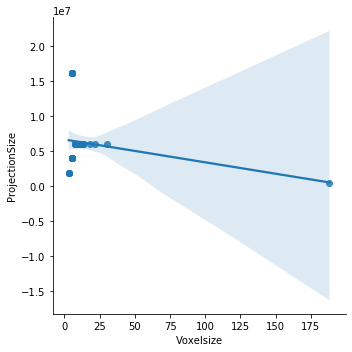

In [155]:
# Convert timedelta to minutes for plotting
# https://stackoverflow.com/a/54729327/323100
# plt.scatter(x=Data['Scan time'].astype('timedelta64[s]') / 3600,
#             y=Data['ProjectionSize']*1e-6)
seaborn.lmplot(data=Data,
               x='Voxelsize',
               y='ProjectionSize'
              )
# plt.ylabel('Projection size [MPx]')
# plt.xlabel('Scan time [h]')
plt.savefig('Scanningtime.png')
plt.show()

In [156]:
Data['PreviewImagePath'] = [sorted(glob.glob(os.path.join(f, '*_spr.bmp'))) for f in Data['Folder']]
Data['PreviewImage'] = [imageio.imread(pip[0])
                        if pip
                        else numpy.random.random((100, 100)) for pip in Data['PreviewImagePath']]

In [157]:
# Make an approximately square overview image
lines = int(numpy.ceil(len(Data)**.5))

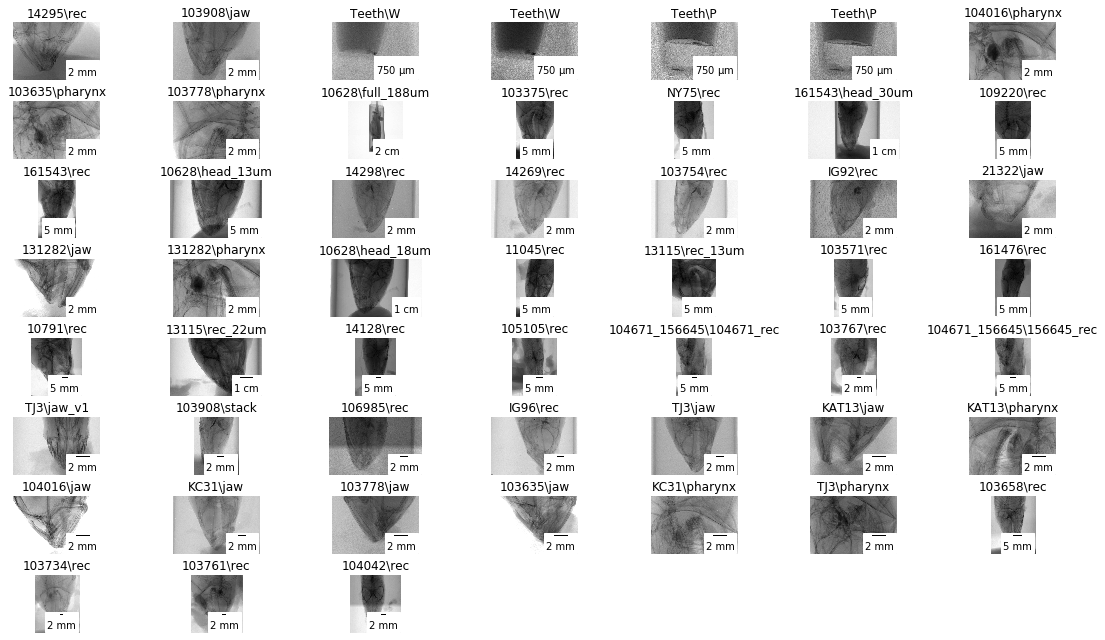

In [158]:
for c, row in Data.iterrows():
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(row.PreviewImage)
    plt.title(os.path.join(row['Fish'], row['Scan']))
    plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                  'um',
                                  color='black',
                                  frameon=True))
    plt.axis('off')
plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig(os.path.join(Root, 'ScanOverviews.png'),
            bbox_inches='tight')
plt.show()

In [159]:
# Convert all reconstructions into a DASK array and save them to disk
# Partially based on http://stackoverflow.com/a/39195332/323100
# and on /LungMetastasis/HighResolutionScanAnalysis.ipynb
Data['OutputNameRec'] = [os.path.join(os.path.dirname(f),
                                      fish + '_' + scan + '.zarr') for f, fish, scan in zip(Data.Folder,
                                                                                                Data.Fish,
                                                                                                Data.Scan)]
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Converting reconstructions to .zarr',
                            total=len(Data)):
    if not os.path.exists(row['OutputNameRec']):
        print('%2s/%2s: Reading %s reconstructions and saving to %s' % (c + 1,
                                                                        len(Data),
                                                                        row['Number of reconstructions'],
                                                                        row['OutputNameRec'][len(Root)+1:]))
        Reconstructions = dask_image.imread.imread(os.path.join(row['Folder'], '*rec*.png'))
        Reconstructions.to_zarr(row['OutputNameRec'],
                                overwrite=True,
                                compressor=Blosc(cname='zstd',
                                                 clevel=3,
                                                 shuffle=Blosc.BITSHUFFLE))

In [160]:
# for file in Data['OutputNameRec']:
#     print(file)
#     dask.array.from_zarr(file)

In [161]:
# Load the reconstructions as zarr arrays
Reconstructions = [dask.array.from_zarr(file) for file in Data['OutputNameRec']]

In [162]:
# How big are the datasets?
Data['Size'] = [rec.shape for rec in Reconstructions]

In [163]:
# The three cardinal directions
directions = ['Axial',
              'Coronal',
              'Sagittal']

In [164]:
# Read or calculate the middle slices, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['Mid_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='Middle images', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc='Fish %s' % row['Fish'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.Middle.%s.png' % (row['Fish'],
                                                            row['Scan'],
                                                            direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'Mid_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate requested axial view
            if 'Axial' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][Data['Size'][c][0] // 2].compute()
            if 'Sagittal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, Data['Size'][c][1] // 2, :].compute()
            if 'Coronal' in direction:
                Data.at[c, 'Mid_' + direction] = Reconstructions[c][:, :, Data['Size'][c][2] // 2].compute()
            # Save the calculated 'direction' view to disk
            imageio.imwrite(outfilepath, (Data.at[c, 'Mid_' + direction]))

In [167]:
# Show middle slices
for c, row in notebook.tqdm(Data.iterrows(),
                            desc='Saving middle images overview',
                            total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MiddleSlices.png' % (row['Fish'], row['Scan']))
    if not os.path.exists(outfilepath):    
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Fish'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['Mid_' + direction])
            if d == 0:
                plt.axhline(row.Size[1] // 2, c=seaborn.color_palette()[0])
                plt.axvline(row.Size[2] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[2]))
            elif d == 1:
                plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[1])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[0]))
            else:
                plt.axhline(row.Size[0] // 2, c=seaborn.color_palette()[2])
                plt.axvline(row.Size[d] // 2, c=seaborn.color_palette()[0])
                plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                              'um',
                                              color=seaborn.color_palette()[1]))
            plt.title('%s, %s' % (os.path.join(row['Fish'], row['Scan']),
                                  direction + ' Middle slice'))
            plt.axis('off')
            plt.savefig(outfilepath,
                        transparent=True,
                        bbox_inches='tight')
        plt.show()

In [168]:
# Read or calculate the directional MIPs, put them into the dataframe and save them to disk
for d, direction in enumerate(directions):
    Data['MIP_' + direction] = [None] * len(Reconstructions)
for c, row in notebook.tqdm(Data.iterrows(), desc='MIPs', total=len(Data)):
    for d, direction in notebook.tqdm(enumerate(directions),
                                      desc='%s' % row['Fish'],
                                      leave=False,
                                      total=len(directions)):
        outfilepath = os.path.join(os.path.dirname(row['Folder']),
                                   '%s.%s.MIP.%s.png' % (row['Fish'],
                                                      row['Scan'],
                                                      direction))
        if os.path.exists(outfilepath):
            Data.at[c, 'MIP_' + direction] = imageio.imread(outfilepath)
        else:
            # Generate MIP
            Data.at[c, 'MIP_' + direction] = Reconstructions[c].max(axis=d).compute()
            # Save it out
            imageio.imwrite(outfilepath, Data.at[c, 'MIP_' + direction].astype('uint8'))

In [169]:
# Show MIP slices
for c, row in notebook.tqdm(Data.iterrows(), desc='Saving MIP images overview', total=len(Data)):
    outfilepath = os.path.join(os.path.dirname(row['Folder']),
                               '%s.%s.MIPs.png' % (row['Fish'], row['Scan']))
    if not os.path.exists(outfilepath):    
        for d, direction in notebook.tqdm(enumerate(directions),
                                          desc=row['Fish'],
                                          leave=False,
                                          total=len(directions)):
            plt.subplot(1, 3, d + 1)
            plt.imshow(row['MIP_' + direction])
            plt.gca().add_artist(ScaleBar(row['Voxelsize'],
                                          'um'))
            plt.title('%s, %s' % (os.path.join(row['Fish'], row['Scan']),
                                  direction + ' MIP'))
            plt.axis('off')
        plt.savefig(outfilepath,
                    transparent=True,
                    bbox_inches='tight')
        plt.show()

In [170]:
print('At the moment, we have previewed %s datasets' % len(Data))

At the moment, we have previewed 52 datasets
